<a href="https://colab.research.google.com/github/megha5401/Shadow_generation/blob/main/shadow_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --quiet opencv-python-headless numpy matplotlib

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Display helper
def show(img, title="", cmap=None):
    plt.figure(figsize=(8,6))
    plt.title(title)
    plt.axis('off')
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
    else:
        plt.imshow(img, cmap=cmap)
    plt.show()


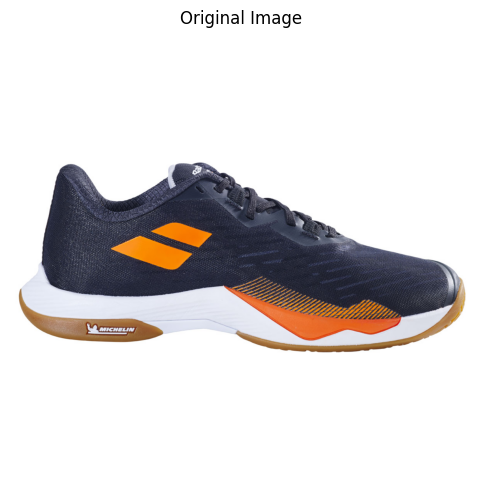

Loaded: download6.jpg size: (1200, 1200, 3)


In [3]:
# STEP 1 — Load download6.jpg
filename = "download6.jpg"
img = cv2.imread(filename)

if img is None:
    raise Exception("Error: upload download6.jpg to Colab first.")

h, w = img.shape[:2]
show(img, "Original Image")

print("Loaded:", filename, "size:", img.shape)

Segmenting shoe using refined GrabCut...


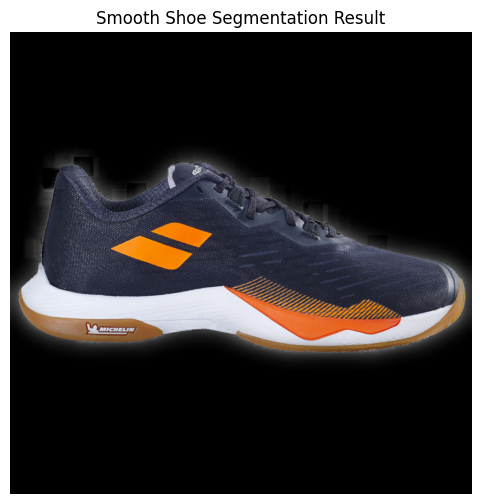

In [7]:
# STEP 2 — AUTO SHOE SEGMENTATION (Smooth Refined GrabCut)
print("Segmenting shoe using refined GrabCut...")

# Initial GrabCut mask
gc_mask = np.zeros(img.shape[:2], np.uint8)

bgModel = np.zeros((1,65), np.float64)
fgModel = np.zeros((1,65), np.float64)

rect = (10, 10, w-20, h-20)

cv2.grabCut(img, gc_mask, rect, bgModel, fgModel, 60, cv2.GC_INIT_WITH_RECT)

# Convert GrabCut output (0/2 = bg, 1/3 = fg)
shoe_mask = np.where((gc_mask == 0) | (gc_mask == 2), 0, 1).astype("uint8")

# Morphology to smooth edges (7 -> 3)
kernel = np.ones((3,3), np.uint8)

# Fill tiny gaps
shoe_mask = cv2.morphologyEx(shoe_mask, cv2.MORPH_CLOSE, kernel, iterations=2)
# Remove small noise
shoe_mask = cv2.morphologyEx(shoe_mask, cv2.MORPH_OPEN, kernel, iterations=1)

# Erode mask slightly to remove halo edges
clean_mask = cv2.erode(shoe_mask, np.ones((3,3), np.uint8), iterations=1)
# Feather mask more softly for natural edge (blur mask)
clean_mask = cv2.GaussianBlur(clean_mask.astype("float32"), (25, 25), 10)

# Smooth mask using original image edges
soft_mask = cv2.ximgproc.guidedFilter(
    guide=img,
    src=clean_mask.astype('float32'),
    radius=25,
    eps=1e-6
)

# Convert back to 0–1 mask
soft_mask = np.clip(soft_mask, 0, 1)

# Apply clean mask to get smooth shoe cut
shoe_only = (img.astype("float32") * soft_mask[:, :, None]).astype("uint8")

# Display result
show(shoe_only, "Smooth Shoe Segmentation Result")


Creating shifted shoe-shaped shadow mask...


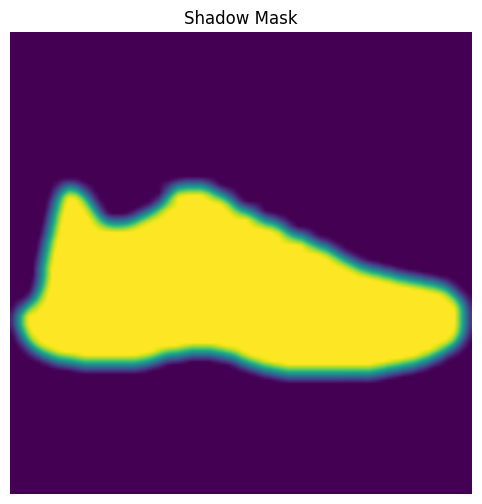

In [8]:
print("Creating shifted shoe-shaped shadow mask...")

hard_mask = (shoe_mask > 0.5).astype("uint8")   # use hard mask for shadow
h, w = hard_mask.shape
shift = int(h * 0.05)
M = np.float32([[1, 0, 0],
                [0, 1, shift]])

shifted_mask = cv2.warpAffine(hard_mask, M, (w, h))

kernel = np.ones((9, 9), np.uint8)
shifted_mask = cv2.erode(shifted_mask, kernel, iterations=1)

shadow_mask = cv2.GaussianBlur(shifted_mask.astype("float32"), (51,51), 25)
shadow_mask = np.clip(shadow_mask, 0, 1)

show(shadow_mask, "Shadow Mask")


 Applying shadow


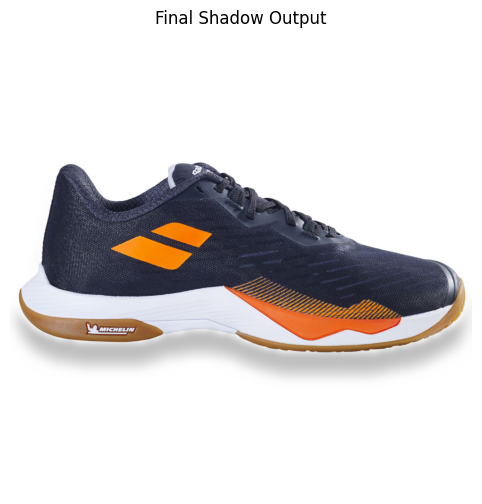

In [9]:
print(" Applying shadow")
shadow_float = shadow_mask.copy()

# Remove shadow only where shoe is VERY strong
shoe_area = (shoe_mask > 0.5)
shadow_float[shoe_area] = 0

shadow_float = cv2.GaussianBlur(shadow_float, (21,21), 12)

blurred = cv2.GaussianBlur(shadow_float, (21,21), 12)

# Make blurred edges darker so they match shadow (remove light gray)
shadow_float = np.minimum(shadow_float, blurred)

# Ensure mask still has values
if shadow_float.max() < 0.1:
    print("Warning: Shadow mask too weak — boosting it.")
    shadow_float = shadow_mask

shadow_strength = 0.25
shadow_multiplier = 1 - (shadow_strength * shadow_float)
shadow_multiplier = shadow_multiplier[:, :, None]

result = img.astype("float32").copy()
result = result * shadow_multiplier
result = np.clip(result, 0, 255).astype("uint8")
show(result, "Final Shadow Output")


In [10]:
# STEP 5 — Save ONLY the final output
print("Saving final output image...")
output_path = "final_shadow_output6.png"
cv2.imwrite(output_path, result)
print("image saved as:", output_path)


Saving final output image...
image saved as: final_shadow_output6.png
